## Introduction
This assessment is designed to test the core skills required for a successful data analyst at
Reboot. The assessment will require you to source, extract, clean, and visualise data to answer
the research question presented below.
## Research Question
The <ins>rise of Veganism in the UK</ins> has prompted restaurants to include **vegan friendly** options on
their menus. While some restaurants have adapted with great speed, others have lagged
behind. Your task is to find the <ins>UK cities that are most suitable for vegans to eat out in</ins>.

To answer this question, we would like you to find the number of <ins>vegan friendly restaurants
per capita in each of the top 20 UK cities listed on TripAdvisor</ins>. Once the data has been
collected and processed as appropriate, you will need to create a data visualisation dashboard
to display your results.
Feel free to supplement this data with anything you deem appropriate to better answer the
research question.

In [1]:
from bs4 import BeautifulSoup
import requests

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from geopy import Nominatim
import geopy
import geopandas
from geopy.exc import GeocoderTimedOut

import folium
import time
from folium.plugins import MarkerCluster

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

In order to automatize the data collection for each country in [TripAdvisor UK]('https://www.tripadvisor.co.uk/Restaurants-g186216-United_Kingdom.html'), we're going to create a crawler which iterates through each webpage and save the information we need in a DataFrame.

First of all we establish a connection with the page using requests and then check the content of the Body using the library BeautifulSoup.

In [2]:
def web_to_soup(url):
    header= {"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.106 Safari/537.36"}

    response=requests.get(url, headers=header)
    soup = BeautifulSoup(response.text, "html.parser")
    
    return soup

In [3]:
soup=web_to_soup('https://www.tripadvisor.co.uk/Restaurants-g186216-United_Kingdom.html')

From the main page we can extract the subdirectories for each city which can be added to the [main page]('https://www.tripadvisor.co.uk/') url in order to find the specific information.

In [4]:
main_page='https://www.tripadvisor.co.uk'

cities_subs=[i.find('a')['href'] for i in soup.findAll('div', {'class':'geo_name'})]
cities_subs

['/Restaurants-g186338-London_England.html',
 '/Restaurants-g187069-Manchester_Greater_Manchester_England.html',
 '/Restaurants-g186402-Birmingham_West_Midlands_England.html',
 '/Restaurants-g186525-Edinburgh_Scotland.html',
 '/Restaurants-g186534-Glasgow_Scotland.html',
 '/Restaurants-g186411-Leeds_West_Yorkshire_England.html',
 '/Restaurants-g186337-Liverpool_Merseyside_England.html',
 '/Restaurants-g186220-Bristol_England.html',
 '/Restaurants-g186364-Sheffield_South_Yorkshire_England.html',
 '/Restaurants-g186356-Nottingham_Nottinghamshire_England.html',
 '/Restaurants-g186334-Leicester_Leicestershire_England.html',
 '/Restaurants-g186460-Cardiff_South_Wales_Wales.html',
 '/Restaurants-g186394-Newcastle_upon_Tyne_Tyne_and_Wear_England.html',
 '/Restaurants-g186273-Brighton_East_Sussex_England.html',
 '/Restaurants-g186470-Belfast_Northern_Ireland.html',
 '/Restaurants-g186346-York_North_Yorkshire_England.html',
 '/Restaurants-g186332-Blackpool_Lancashire_England.html',
 '/Restauran

While inspecting the webpage we can notice that under the DIV pageNumbers, each span represent a page of contents and the associated link contain useful information to facilitate the data collection

<center><img src='./tripadvisor_pages.png'><center>

**/RestaurantSearch-g186338-oa150-zfz10697-London_England.html**

A closer look to see how the URL is built:

* Command:  **/RestaurantSearch**
* City code:  **g186338**
* Page selector:  **oa0**
* Vegan_friendly_filter:  **zfz10697**
* City:  **London_England**

Using this information we can create a dataframe containing these initial details and build a new url to direct our search

In [5]:
df=pd.DataFrame(data=[i.split("-")[1:] for i in cities_subs], columns=['city_code', 'city'])
df.head(7)

,city_code,city
0,g186338,London_England.html
1,g187069,Manchester_Greater_Manchester_England.html
2,g186402,Birmingham_West_Midlands_England.html
3,g186525,Edinburgh_Scotland.html
4,g186534,Glasgow_Scotland.html
5,g186411,Leeds_West_Yorkshire_England.html
6,g186337,Liverpool_Merseyside_England.html


Now that we have the url for each of the main 20 cities in UK, we can iterate through every restaurant and add it to a dataframe that we'll later use to easily collect all the information we need

In [6]:
def get_restaurants(row):
    
    """Get all the vegan friendly restaurants and organize them in a dataframe"""
    
    columns=['command', 'city_code', 'restaurant_code', 'section', 'restaurant_name', 'city']
    
    command='/RestaurantSearch'
    veg_filter='zfz10697'
    page=0
    restaurants_df=pd.DataFrame(columns=columns)
    
    
    running=True
    while running:
        
        if row['city_code']=='g186394':
            row['city']='Newcastle_upon_Tyne_Tyne_and_Wear_England.html'
        else:
            row=row
        
        #enter the restaurants page
        search_url = main_page + command + '-' + row['city_code'] + '-oa' + str(page) + '-' + veg_filter + '-' + row['city']
        soup=web_to_soup(search_url)

        #get links for each restaurant
        link_restaurants=[i['href'] for i in soup.findAll('a', {'class':'_15_ydu6b'}) if i.text[0].isdigit()]

        #split the subdirectories and add them in the dataframe
        data=[i.split("-") for i in link_restaurants]
        
        restaurants_df=restaurants_df.append(pd.DataFrame(data=data, columns=columns))
        
        if any(restaurants_df['restaurant_code'].duplicated()) is True:
            print('Done')
            running=False
            break
        
        else:
#             print('{}'.format(page))
            page+=30
            continue
            
    return restaurants_df



uk_restaurants=[]
counter=0
for i in range(len(df)):
    print("\n"+str(counter+1), end='\n\n')
    print('Processing restaurants in {}'.format(df.loc[i, 'city'].split("_")[0]))
    uk_restaurants.append(get_restaurants(df.loc[i]))
    counter+=1

    
    
restaurants_df=pd.concat(uk_restaurants).reset_index()
restaurants_df.drop('index', axis=1, inplace=True)


1

Processing restaurants in London
Done

2

Processing restaurants in Manchester
Done

3

Processing restaurants in Birmingham
Done

4

Processing restaurants in Edinburgh
Done

5

Processing restaurants in Glasgow
Done

6

Processing restaurants in Leeds
Done

7

Processing restaurants in Liverpool
Done

8

Processing restaurants in Bristol
Done

9

Processing restaurants in Sheffield
Done

10

Processing restaurants in Nottingham
Done

11

Processing restaurants in Leicester
Done

12

Processing restaurants in Cardiff
Done

13

Processing restaurants in Newcastle
Done

14

Processing restaurants in Brighton
Done

15

Processing restaurants in Belfast
Done

16

Processing restaurants in York
Done

17

Processing restaurants in Blackpool
Done

18

Processing restaurants in Southampton
Done

19

Processing restaurants in Bournemouth
Done

20

Processing restaurants in Norwich
Done


In [7]:
backup_df=restaurants_df.copy()
# restaurants_df=backup_df

Since we have to calculate the amount of vegan friendly restaurants per capita, we'll need the population of each city. In order to do that we can download from [World Population Review]('https://worldpopulationreview.com/world-cities') the csv file containing all the uk's cities and the related population.

In [8]:
df['name']=[i.split('_')[0] for i in df['city']]
df.loc[12, 'name']='Newcastle upon Tyne'

uk_cities=pd.read_csv('ukpopulation.csv',index_col='name')
pop_dict=uk_cities[uk_cities.index.isin(df['name'])].to_dict()['2021']
df['population']=df['name'].map(pop_dict)

In order to identify eventual duplicates during the collection of the data, we can use the column restaurant_code we've previously created.

In [9]:
restaurants_df.shape

(12387, 6)

In [10]:
restaurants_df['restaurant_code'].drop_duplicates(inplace=True)

In [11]:
restaurants_df.dropna(axis=0, inplace=True)

In [12]:
name=[i.split("_")[0] for i in restaurants_df['city']]
restaurants_df['name']=name

In [13]:
restaurants_df=restaurants_df[restaurants_df['city_code'].isin(df['city_code'])]
restaurants_df.reset_index(inplace=True)
restaurants_df.drop('index',axis=1, inplace=True)
restaurants_df

,command,city_code,restaurant_code,section,restaurant_name,city,name
0,/Restaurant_Review,g186338,d21302648,Reviews,Hibox,London_England.html,London
1,/Restaurant_Review,g186338,d783897,Reviews,Indian_Room,London_England.html,London
2,/Restaurant_Review,g186338,d14134252,Reviews,Scarlett_Green,London_England.html,London
3,/Restaurant_Review,g186338,d813149,Reviews,Taste_Of_Nawab,London_England.html,London
4,/Restaurant_Review,g186338,d15614126,Reviews,The_Rajdoot_Hampstead,London_England.html,London
...,...,...,...,...,...,...,...
11977,/Restaurant_Review,g186342,d6740910,Reviews,Ciscoe_s_Pan_Asian_Sushi,Norwich_Norfolk_East_Anglia_England.html,Norwich
11978,/Restaurant_Review,g186342,d9558807,Reviews,Brick_Pizza,Norwich_Norfolk_East_Anglia_England.html,Norwich
11979,/Restaurant_Review,g186342,d8288163,Reviews,Donnelli_s_Pizzeria,Norwich_Norfolk_East_Anglia_England.html,Norwich
11980,/Restaurant_Review,g186342,d731365,Reviews,Benedicts,Norwich_Norfolk_East_Anglia_England.html,Norwich


Now we can calculate how many <ins>vegan friendly restaurants there are  per capita in each of the top 20 UK cities listed on TripAdvisor</ins>.

In [14]:
vegans_friendly=dict(restaurants_df.groupby('name')['restaurant_code'].count())
df['avenues_counter']=df['name'].map(vegans_friendly)
df.loc[12, 'avenues_counter']=vegans_friendly['Newcastle']

In [15]:
df['veg_friendly_per_capita']=(df['avenues_counter']/df['population'])

In [16]:
restaurants_df

,command,city_code,restaurant_code,section,restaurant_name,city,name
0,/Restaurant_Review,g186338,d21302648,Reviews,Hibox,London_England.html,London
1,/Restaurant_Review,g186338,d783897,Reviews,Indian_Room,London_England.html,London
2,/Restaurant_Review,g186338,d14134252,Reviews,Scarlett_Green,London_England.html,London
3,/Restaurant_Review,g186338,d813149,Reviews,Taste_Of_Nawab,London_England.html,London
4,/Restaurant_Review,g186338,d15614126,Reviews,The_Rajdoot_Hampstead,London_England.html,London
...,...,...,...,...,...,...,...
11977,/Restaurant_Review,g186342,d6740910,Reviews,Ciscoe_s_Pan_Asian_Sushi,Norwich_Norfolk_East_Anglia_England.html,Norwich
11978,/Restaurant_Review,g186342,d9558807,Reviews,Brick_Pizza,Norwich_Norfolk_East_Anglia_England.html,Norwich
11979,/Restaurant_Review,g186342,d8288163,Reviews,Donnelli_s_Pizzeria,Norwich_Norfolk_East_Anglia_England.html,Norwich
11980,/Restaurant_Review,g186342,d731365,Reviews,Benedicts,Norwich_Norfolk_East_Anglia_England.html,Norwich


### DATA VISUALIZATION

We can now visualize some of the results obtained:

1. At first glance, **London**, with a total of 4825 avenues is placed in the first place <ins>as per quantity of vegan friendly restaurants</ins>, follow **Edinburgh** with 764, **Glasgow** with 602 and **Birmingham** with 537

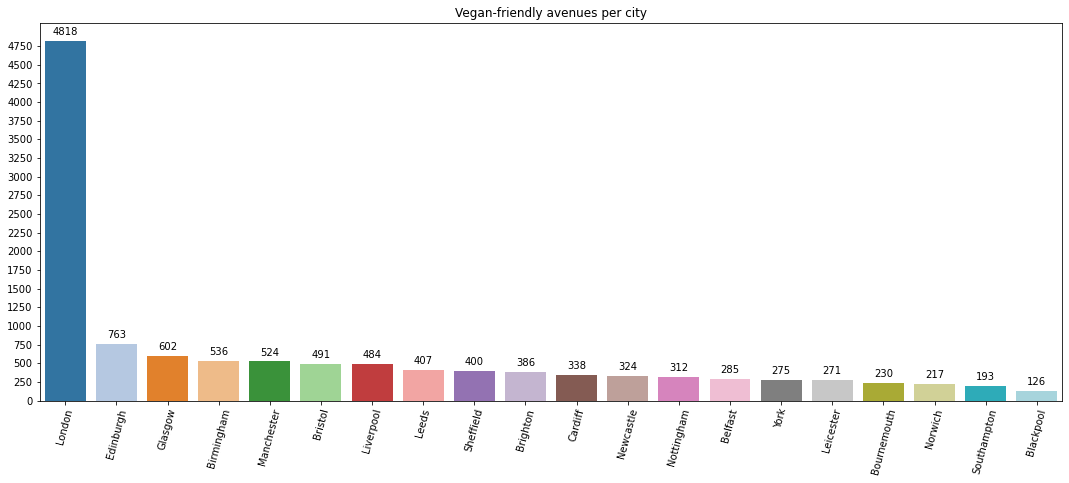

In [17]:
filt=restaurants_df.groupby('name')['command'].count().sort_values(ascending=False)
fig=plt.figure(figsize=(15, 6))
plt.title("Vegan-friendly avenues per city")

splot=sns.barplot(x=filt.index.tolist(), y=filt.values.tolist(), palette='tab20')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
fig.tight_layout()
plt.xticks(rotation=75)
plt.yticks(range(0, 5000, 250))
plt.show()

2. When we calculate and represents the <ins>vegan friendly restaurants per capita in each of the top 20 UK cities listed on TripAdvisor</ins>, we quickly see that London is no longer leading in the graph, instead the higher presence of vegan friendly restaurants per capita is registered in: 

* Brighton
* York
* Newcastle upon Tyne

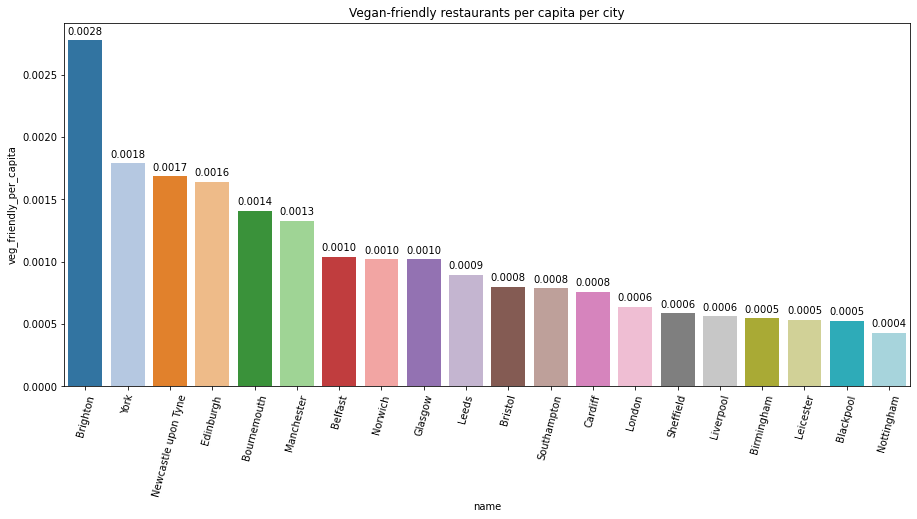

In [18]:
veg_per_capita=df[['name','veg_friendly_per_capita']].sort_values(by='veg_friendly_per_capita', ascending=False)

fig=plt.figure(figsize=(13, 6))
plt.title('Vegan-friendly restaurants per capita per city')
splot=sns.barplot(data=veg_per_capita, x='name', y='veg_friendly_per_capita', palette='tab20')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
fig.tight_layout()
plt.xticks(rotation=75)
plt.show()

___

Now that we have the link for each restaurant in a dataframe, we can collect further information about the avenue and visualize it in a map. In order to do that, the library Folium, will give the possibility to show and interact with the UK map, making it easier to visualize the avenues in the territory, but also get immediate information about it.

In [19]:
links=[]
for i in range(len(restaurants_df.loc[:, :'city'])):
    links.append(main_page + "-".join(restaurants_df.loc[i, :'city']))
    
restaurants_df['link']=links

def restaurants_details(link):
    
    """Enter the restaurant's Tripadvisor web page and collect:
    
        -location
        -phone number
        -price range
        -cuisine
        -rating"""
    
    info=dict()
    container=[]
    soup=web_to_soup(link)
    
    try:
        #get location
        info['location']=soup.body.findAll('a', {'class': '_2wKz--mA _27M8V6YV'})[0].text
        #get phone number
        info['phone']=soup.body.findAll('span', {'class':'_2saB_OSe'})[-1].text
        #get price range
        info['price']=soup.body.findAll('a', {'class':'_2mn01bsa'})[0].text
        #get cuisine
        info['cuisine']=soup.body.findAll('a', {'class':'_2mn01bsa'})[1].text
        #get rating
        info['rating']=re.findall("\d.\d",soup.body.findAll('span', {'class':'r2Cf69qf'})[-1].text)[0]
                
    except:
        pass
        
    return info

In [20]:
%%time
av_info=restaurants_df.loc[:, 'link'].map(restaurants_details)

CPU times: user 54min 16s, sys: 55.9 s, total: 55min 12s
Wall time: 4h 39min 6s


In [21]:
# import pickle

# avenues_details=open('avenues_details.pkl', 'wb')
# pickle.dump(av_info, avenues_details)
# avenues_details.close()

# file=open('avenues_details.pkl' ,'rb')
# avenues_details=pickle.load(file)

In [22]:
avenues_details=pd.concat([restaurants_df, pd.DataFrame([i.values() for i in av_info], columns=['location', 'phone', 'price_range', 'cuisine', 'rating'])], axis=1).drop(['command', 'section', 'city'], axis=1)
avenues_details.head()

,city_code,restaurant_code,restaurant_name,name,link,location,phone,price_range,cuisine,rating
0,g186338,d21302648,Hibox,London,https://www.tripadvisor.co.uk/Restaurant_Revie...,"48 Goodge Street, London W1T 4LX England",+44 20 7580 9312,£,Lebanese,5.0
1,g186338,d783897,Indian_Room,London,https://www.tripadvisor.co.uk/Restaurant_Revie...,"59 Bedford Hill Balham, London SW12 9EZ England",+44 20 8675 8611,££ - £££,Indian,5.0
2,g186338,d14134252,Scarlett_Green,London,https://www.tripadvisor.co.uk/Restaurant_Revie...,"4 Noel Street Soho, London W1F 8GB England",+44 20 3653 2010,££ - £££,Australian,5.0
3,g186338,d813149,Taste_Of_Nawab,London,https://www.tripadvisor.co.uk/Restaurant_Revie...,"97 Colney Hatch Lane, London N10 1LR England",+351 929 170 320,££ - £££,Indian,5.0
4,g186338,d15614126,The_Rajdoot_Hampstead,London,https://www.tripadvisor.co.uk/Restaurant_Revie...,"104 Fleet Road Hampstead, London NW3 2QX England",+44 20 7485 1329,££ - £££,Indian,5.0


In [74]:
def get_coordinates(location, attempt=1, max_attempt=5):
    
    """Turn an address into coordinates"""
    
    locator = Nominatim(user_agent="uk_coordinates")
        
    try:
        time.sleep(2.5)
    
        coordinates = locator.geocode(location)

        if coordinates is None:
            coordinates=location, (51, 0)
        else:
            coordinates = locator.geocode(location)
            
        return coordinates[1]
            
    except GeocoderTimedOut:
        
        time.sleep(2.5)
                
        if attempt <= max_attempt:
            
            return get_coordinates(location, attempt=attempt+1)
        
            


In [76]:
get_coordinates(avenues_details.loc[256, 'location'])

(51.4256431, -0.0487489)

By iterating through the new column created: "location", we can create an interactive marker for each avenue and show useful information when clicked.

In [101]:
uk_map=folium.Map(location=[51.50, 0.12], zoom_start=6, tiles='OpenStreetMap')

marker_cluster=MarkerCluster().add_to(uk_map)

#100 sample example
for i in avenues_details.sample(frac=1).index.tolist()[:100]:

    label=f"""

    <div>

    <b>NAME</b>: {avenues_details.loc[i,'restaurant_name']} <br><br>
    <b>CONTACT</b>: {avenues_details.loc[i,'phone']} <br><br>
    <b>PRICE</b>: {avenues_details.loc[i,'price_range']} <br><br>
    <b>CUISINE</b>: {avenues_details.loc[i,'cuisine']} <br><br>
    <b>RATING</b>: {avenues_details.loc[i,'rating']} <br><br>

    </div>

    """

    time.sleep(2)
    coordinates=get_coordinates(avenues_details.loc[i, 'location'])
    location=folium.Marker(coordinates, popup=label, tooltip='Click for more!', icon=folium.Icon(icon='leaf', color='green', prefix='fa')).add_to(marker_cluster)

In [103]:
uk_map.save('uk_vegan_friendly_restaurants.html')